In [1]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from ucimlrepo import fetch_ucirepo
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
polish_companies_bankruptcy = fetch_ucirepo(id=365)
features = polish_companies_bankruptcy.data.features
target = polish_companies_bankruptcy.data.targets

In [3]:
features.head()

,year,A1,A2,A3,A4,A5,A6,A7,A8,A9,...,A55,A56,A57,A58,A59,A60,A61,A62,A63,A64
0,1,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,...,348690.0,0.121960,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277
1,1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,...,2304.6,0.121300,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870
2,1,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,...,6332.7,0.241140,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078
3,1,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,...,20545.0,0.054015,0.14207,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497
4,1,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,...,3186.6,0.134850,0.48431,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980


In [4]:
target.head()

,class
0,0
1,0
2,0
3,0
4,0


In [5]:
features.isnull().sum()

year       0
A1         8
A2         8
A3         8
A4       134
        ... 
A60     2152
A61      102
A62      127
A63      134
A64      812
Length: 65, dtype: int64

In [6]:
target.isnull().sum()

class    0
dtype: int64

In [3]:
data = pd.concat([features, target], axis=1)
data.head()
print(data.shape)

(43405, 66)


<Axes: ylabel='class distribution'>

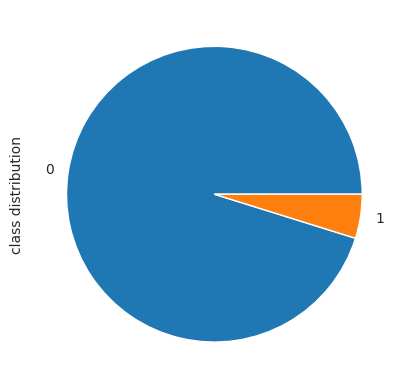

In [8]:
data['class'].value_counts().plot(kind='pie', ylabel="class distribution")


Text(0, 0.5, 'Variance')

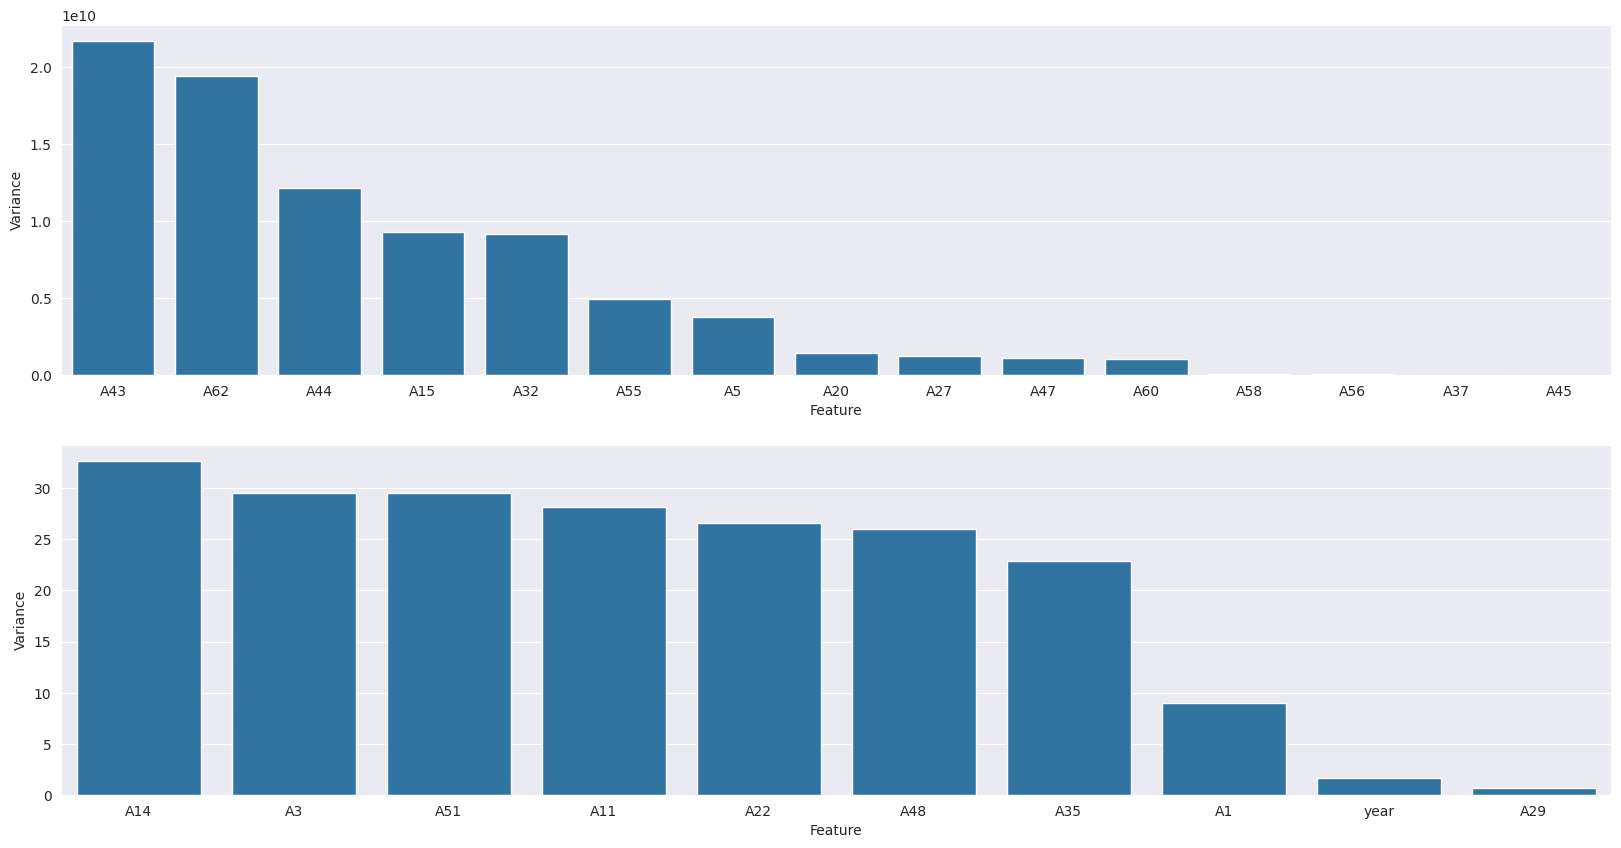

In [4]:
variance = data.var("rows")[:-1]
variance_sorted = variance.sort_values(ascending=False)
x = variance_sorted[:15]

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
sns.barplot(x=x.index, y=x.values, ax=ax[0])
ax[0].set_xlabel('Feature')
ax[0].set_ylabel('Variance')
x = variance_sorted[-10:]
sns.barplot(x=x.index, y=x.values, ax=ax[1])
ax[1].set_xlabel('Feature')
ax[1].set_ylabel('Variance')

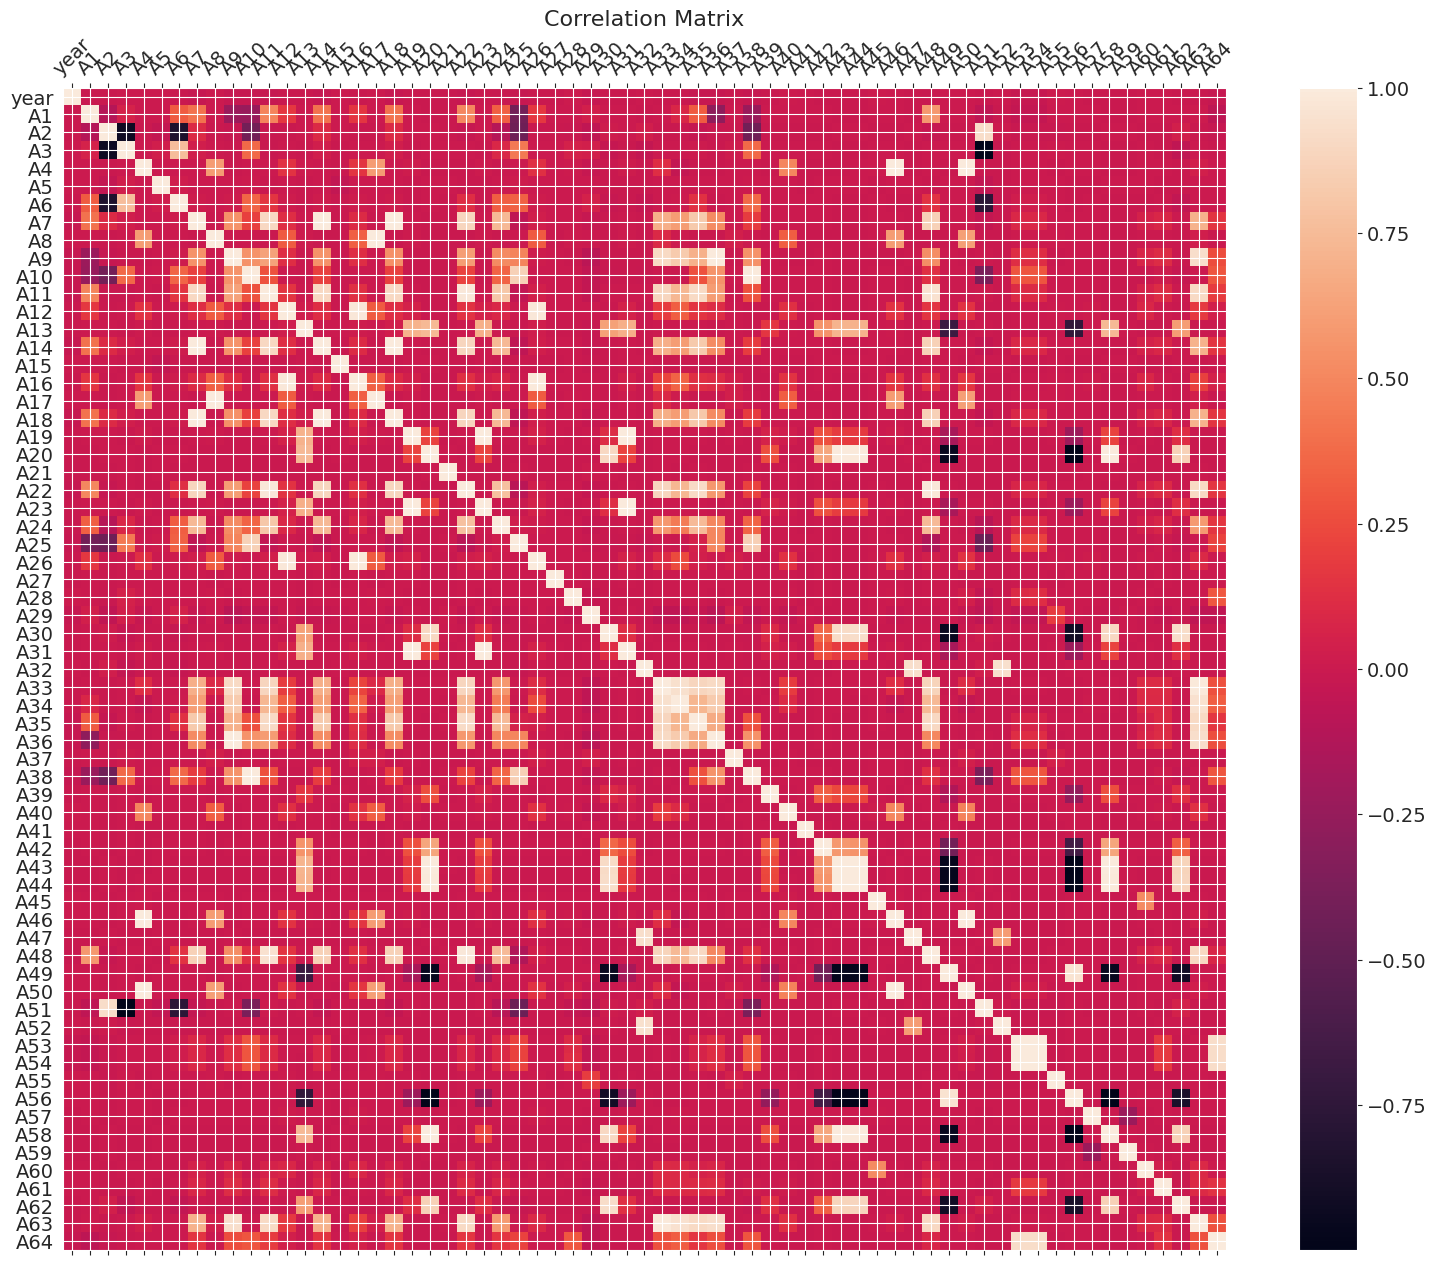

In [10]:
f = plt.figure(figsize=(19, 15))
plt.matshow(features.corr(method="pearson"), fignum=f.number)
plt.xticks(range(features.select_dtypes(['number']).shape[1]), features.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(features.select_dtypes(['number']).shape[1]), features.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [11]:
for col in features.columns:
    print("Skewness:", data[col].skew())
    print("Kurtosis:", data[col].kurtosis())

Skewness: 0.03946169552908803
Kurtosis: -1.081827225406298
Skewness: -114.34511038320505
Kurtosis: 15841.665229021624
Skewness: 56.897037750219454
Kurtosis: 5856.4846366616675
Skewness: -81.87625343984931
Kurtosis: 6866.33693559908
Skewness: 155.58221814654618
Kurtosis: 26386.88158615009
Skewness: -171.77556097783253
Kurtosis: 33057.767885891415
Skewness: -29.366974924528765
Kurtosis: 3893.947134493214
Skewness: 18.90251773695248
Kurtosis: 7537.684532700433
Skewness: 77.37057858993019
Kurtosis: 6894.985158003572
Skewness: 109.09124110599764
Kurtosis: 14568.451043564617
Skewness: 48.878549930063414
Kurtosis: 3614.554972078527
Skewness: 53.49458492109462
Kurtosis: 9253.510269862592
Skewness: 54.90650243001229
Kurtosis: 9880.63069777947
Skewness: 118.00309789797328
Kurtosis: 16028.93057275502
Skewness: 18.902512670028
Kurtosis: 7537.684729643637
Skewness: 15.669358870784851
Kurtosis: 6732.576850326062
Skewness: 57.085818775364395
Kurtosis: 9630.195750389892
Skewness: 76.89031072835007
Kur

### Poniżej próba implementacji (dwie funkcje) Dopasowania do pojęcia klasy (concept closest fit)

In [12]:
def calculate_distance(a, b, max_v, min_v):
    distance = 0
    for i in range(a.size):
        if pd.isnull(a.iloc[i]) or pd.isnull(b.iloc[i]):
            distance += 1
        elif a.iloc[i] == b.iloc[i]:
            distance += 0
        else:
            if not abs(a.iloc[i] - b.iloc[i]):
                print(a.iloc[i], b.iloc[i])
            distance += abs(a.iloc[i] - b.iloc[i]) / abs(max_v.iloc[i] - min_v.iloc[i])
    return distance

In [13]:
def find_lowest_distances(df, index):
    distances = []
    max_v = df.max()
    min_v = df.min()
    for i in index:
        min_dist = np.inf
        idx = 0
        for j, row in df.iterrows():
            if j == i:
                continue
            d = calculate_distance(df.loc[i], row , max_v, min_v)
            if d < min_dist:
                min_dist = d
                idx = j
        distances.append((i, idx))
    return distances

In [5]:
def fill_missing(df, class_column):
    for column in df.columns:
        if column == class_column:
            continue
        mode_by_class = df.groupby(class_column)[column].apply(lambda x: x.mode()[0])
        df[column] = df.apply(
            lambda row: mode_by_class[row[class_column]] if pd.isna(row[column]) else row[column],
            axis=1
        )
    return df

In [6]:
data_filled = fill_missing(data, class_column='class')

In [16]:
data_filled.isnull().sum()

year     0
A1       0
A2       0
A3       0
A4       0
        ..
A61      0
A62      0
A63      0
A64      0
class    0
Length: 66, dtype: int64

In [17]:
 data_filled.duplicated().sum()

np.int64(401)

In [7]:
data_unique = data_filled.drop_duplicates()
data_unique.shape

(43004, 66)

In [19]:
def remove_outliers_column(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    df = df.drop(outliers.index)
    return df

def remove_outliers(df, columns):
    data = df.copy(deep=True)
    for col in columns:
        print(f"Array shape with outliers {col}", data.shape)
        print(f"Variance with outliers {col}: ", data[col].var())
        data = remove_outliers_column(data, col)
        print(f"Array shape without outliers {col}: ", data.shape)
        print(f"Variance without outliers {col}: ", data[col].var())
    return data

In [20]:
def remove_outliers_column_by_class(df, column, class_column, class1, class2):
    class1_data = df[df[class_column] == class1]
    class2_data = df[df[class_column] == class2]

    q1_1 = class1_data[column].quantile(0.25)
    q3_1 = class1_data[column].quantile(0.75)
    iqr_1 = q3_1 - q1_1
    lower_bound_1 = q1_1 - 1.5 * iqr_1
    upper_bound_1 = q3_1 + 1.5 * iqr_1

    q1_2 = class2_data[column].quantile(0.25)
    q3_2 = class2_data[column].quantile(0.75)
    iqr_2 = q3_2 - q1_2
    lower_bound_2 = q1_2 - 1.5 * iqr_2
    upper_bound_2 = q3_2 + 1.5 * iqr_2

    outliers_class1 = class1_data[(class1_data[column] < lower_bound_1) |
                                 (class1_data[column] > upper_bound_1)]
    outliers_class2 = class2_data[(class2_data[column] < lower_bound_2) |
                                 (class2_data[column] > upper_bound_2)]

    all_outliers = outliers_class1.index.union(outliers_class2.index)
    df_clean = df.drop(all_outliers)

    return df_clean

def remove_outliers_by_class(df, columns, class_column, class1, class2):
    data = df.copy(deep=True)
    for col in columns:
        print(f"\nProcessing column: {col}")
        print(f"Initial shape with outliers: {data.shape}")
        print(f"Initial variance by class:")
        print(f"  {class1}: {data[data[class_column] == class1][col].var()}")
        print(f"  {class2}: {data[data[class_column] == class2][col].var()}")

        data = remove_outliers_column_by_class(data, col, class_column, class1, class2)

        print(f"\nAfter removing outliers:")
        print(f"New shape: {data.shape}")
        print(f"New variance by class:")
        print(f"  {class1}: {data[data[class_column] == class1][col].var()}")
        print(f"  {class2}: {data[data[class_column] == class2][col].var()}")

    return data

In [9]:
def clip_outliers_column_by_class(df, column, class_column, class1, class2):
    df_copy = df.copy(deep=True)
    class1_data = df_copy[df_copy[class_column] == class1]
    class2_data = df_copy[df_copy[class_column] == class2]

    q1_1 = class1_data[column].quantile(0.25)
    q3_1 = class1_data[column].quantile(0.75)
    iqr_1 = q3_1 - q1_1
    lower_bound_1 = q1_1 - 1.5 * iqr_1
    upper_bound_1 = q3_1 + 1.5 * iqr_1

    q1_2 = class2_data[column].quantile(0.25)
    q3_2 = class2_data[column].quantile(0.75)
    iqr_2 = q3_2 - q1_2
    lower_bound_2 = q1_2 - 1.5 * iqr_2
    upper_bound_2 = q3_2 + 1.5 * iqr_2

    mask_class1 = (df_copy[class_column] == class1)
    df_copy.loc[mask_class1 & (df_copy[column] < lower_bound_1), column] = lower_bound_1
    df_copy.loc[mask_class1 & (df_copy[column] > upper_bound_1), column] = upper_bound_1

    mask_class2 = (df_copy[class_column] == class2)
    df_copy.loc[mask_class2 & (df_copy[column] < lower_bound_2), column] = lower_bound_2
    df_copy.loc[mask_class2 & (df_copy[column] > upper_bound_2), column] = upper_bound_2

    return df_copy

def clip_outliers_by_class(df, columns, class_column, class1, class2):
    data = df.copy(deep=True)
    for col in columns:
        print(f"\nProcessing column: {col}")
        print(f"Initial shape: {data.shape}")
        print(f"Initial variance by class:")
        print(f"{class1}: {data[data[class_column] == class1][col].var()}")
        print(f"{class2}: {data[data[class_column] == class2][col].var()}")

        data = clip_outliers_column_by_class(data, col, class_column, class1, class2)

        print(f"\nAfter clipping outliers:")
        print(f"Shape remains: {data.shape}")
        print(f"New variance by class:")
        print(f"{class1}: {data[data[class_column] == class1][col].var()}")
        print(f"{class2}: {data[data[class_column] == class2][col].var()}")

    return data

In [10]:
data_clean = clip_outliers_by_class(data_filled, variance_sorted[:].index, "class", 0, 1)
data_clean = data_clean.drop(columns=list(variance_sorted[-2:].index))
X = data_clean.iloc[:, :-1]
Y = data_clean.iloc[:, -1]


Processing column: A43
Initial shape: (43405, 66)
Initial variance by class:
0: 22703366436.753994
1: 2824269.862314939

After clipping outliers:
Shape remains: (43405, 66)
New variance by class:
0: 3508.289774924135
1: 5385.839262711525

Processing column: A62
Initial shape: (43405, 66)
Initial variance by class:
0: 20290226864.843094
1: 739902532.8757762

After clipping outliers:
Shape remains: (43405, 66)
New variance by class:
0: 3477.2994829444906
1: 10786.417869188519

Processing column: A44
Initial shape: (43405, 66)
Initial variance by class:
0: 12686669589.09419
1: 1971401.725297571

After clipping outliers:
Shape remains: (43405, 66)
New variance by class:
0: 1345.1472946973165
1: 1830.6727285612142

Processing column: A15
Initial shape: (43405, 66)
Initial variance by class:
0: 9579387311.999628
1: 3253797084.265984

After clipping outliers:
Shape remains: (43405, 66)
New variance by class:
0: 4007131.936841323
1: 23168265.662468728

Processing column: A32
Initial shape: (4

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(*(X, Y), test_size=0.2, stratify=Y)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(34724, 63)
(34724,)
(8681, 63)
(8681,)


418


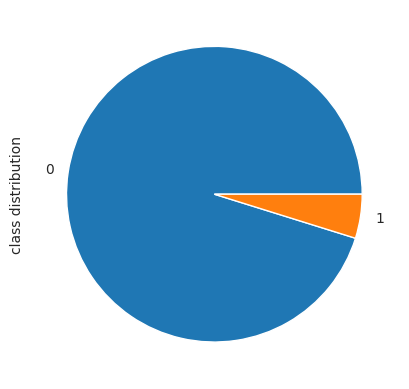

In [12]:
Y_test.value_counts().plot(kind='pie', ylabel="class distribution")
print(Y_test[Y_test == 1].size)

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
np.mean(X_train_scaled), np.std(X_train_scaled)

(np.float64(-3.537753256929936e-17), np.float64(0.9999999999999999))

In [14]:
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
variance_ratio = pca.explained_variance_ratio_
print('Explained variability per principal component: {}'.format(variance_ratio))
print(len(variance_ratio))

Explained variability per principal component: [0.37461912 0.13614853 0.09342041 0.05593584 0.03461503 0.03309714
 0.02564693 0.02125497 0.01871612 0.01715577 0.01613949 0.01504527
 0.01428835 0.01396706 0.01237951 0.01118805 0.00947955 0.00895109
 0.00783971 0.00732535 0.00665724 0.00610074 0.00571851 0.0054816 ]
24


In [15]:
model = KNeighborsClassifier(n_neighbors=2)
model.fit(X_train_pca, Y_train)

KNeighborsClassifier(n_neighbors=2)


Test results:

Accuracy: 0.9762700149752332

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      8263
           1       0.99      0.51      0.68       418

    accuracy                           0.98      8681
   macro avg       0.98      0.76      0.83      8681
weighted avg       0.98      0.98      0.97      8681



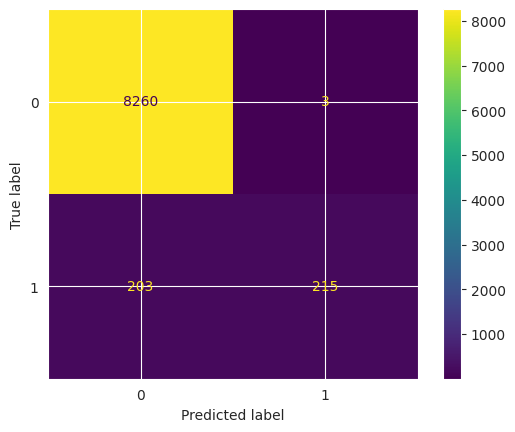

In [16]:
# predictions = model.predict(X_train_pca)
# result = accuracy_score(Y_train_resampled, predictions)
#
# print("\nTrain results:")
# print("\nAccuracy:", result)
# print("\nClassification Report:")
# print(classification_report(Y_train_resampled, predictions))

predictions = model.predict(X_test_pca)
result = accuracy_score(Y_test, predictions)
print("\nTest results:")
print("\nAccuracy:", result)
print("\nClassification Report:")
print(classification_report(Y_test, predictions))

cm = confusion_matrix(Y_test, predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

In [17]:
model = RandomForestClassifier()
model.fit(X_train_pca, Y_train)

RandomForestClassifier()


Test results:

Accuracy: 0.9797258380370925

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      8263
           1       0.98      0.59      0.74       418

    accuracy                           0.98      8681
   macro avg       0.98      0.80      0.86      8681
weighted avg       0.98      0.98      0.98      8681



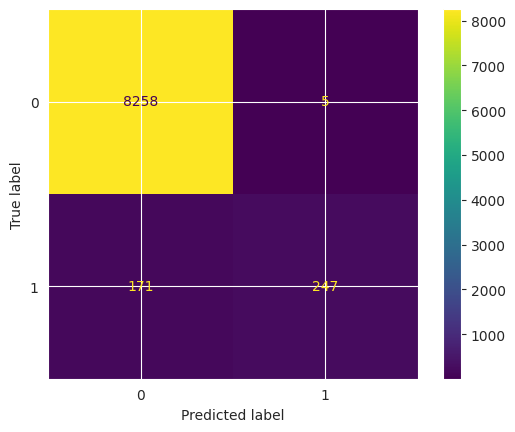

In [18]:
# predictions = model.predict(X_train_pca)
# result = accuracy_score(Y_train_resampled, predictions)
#
# print("\nTrain results:")
# print("\nAccuracy:", result)
# print("\nClassification Report:")
# print(classification_report(Y_train_resampled, predictions))

predictions = model.predict(X_test_pca)
result = accuracy_score(Y_test, predictions)
print("\nTest results:")
print("\nAccuracy:", result)
print("\nClassification Report:")
print(classification_report(Y_test, predictions))

cm = confusion_matrix(Y_test, predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

In [31]:
tsne = TSNE(n_components=2)
X_train_tsne = tsne.fit_transform(X_train_scaled)
print(tsne.kl_divergence_)

2.0855400562286377


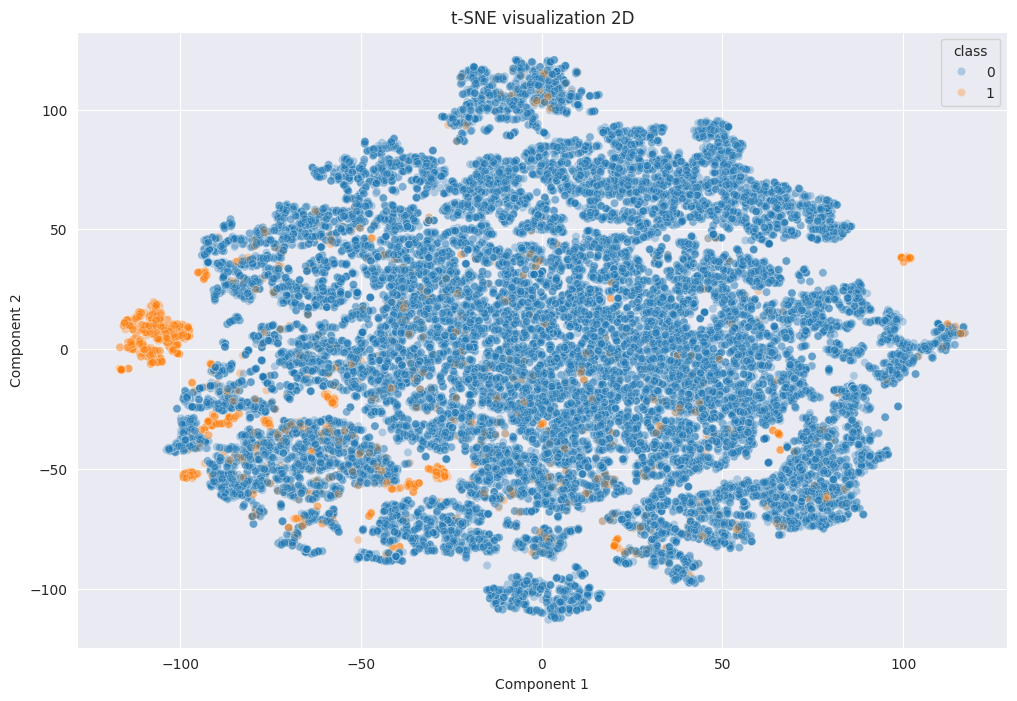

In [32]:
plt.figure(figsize=(12, 8))
fig = sns.scatterplot(x=X_train_tsne[:, 0], y=X_train_tsne[:, 1], hue=Y_train, alpha=0.3)
fig.set_title(label="t-SNE visualization 2D")
fig.set_xlabel("Component 1")
fig.set_ylabel("Component 2")
plt.show()

In [33]:
pca = PCA(n_components=2)
X_train_pca_vis = pca.fit_transform(X_train_scaled)

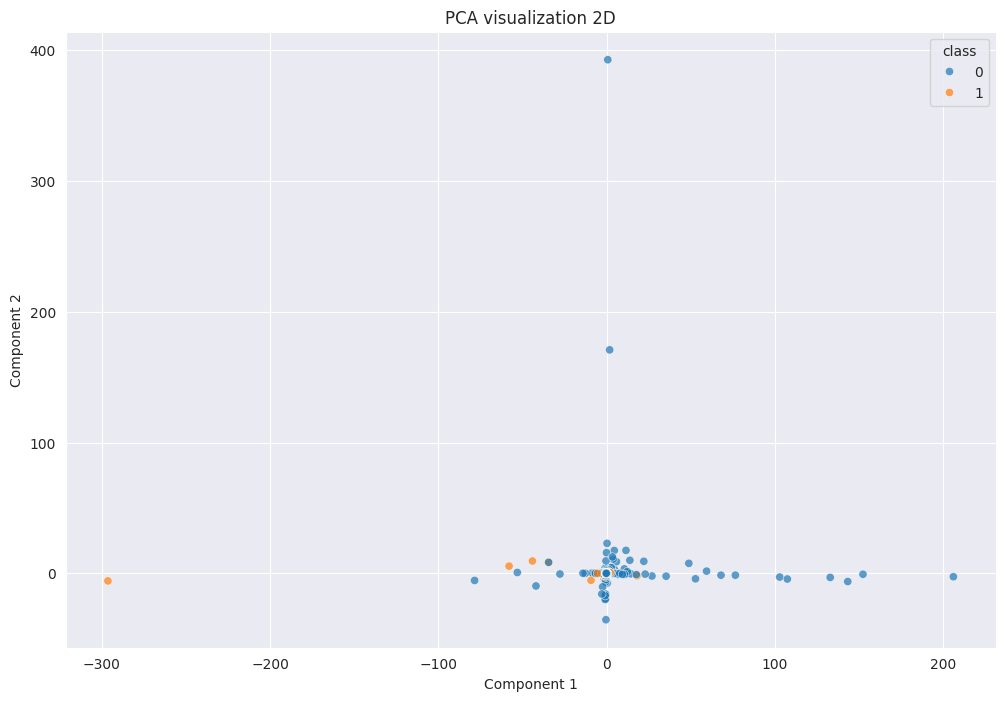

In [34]:
plt.figure(figsize=(12, 8))
fig = sns.scatterplot(x=X_train_pca_vis[:, 0], y=X_train_pca_vis[:, 1], hue=Y_train, alpha=0.7)
fig.set_title(label="PCA visualization 2D")
fig.set_xlabel("Component 1")
fig.set_ylabel("Component 2")
plt.show()